In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import re
import nltk
import spacy
from nltk.corpus import stopwords 
# nltk.download('stopwords')
from collections import Counter
from sklearn import model_selection, feature_extraction, metrics
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import svm

Import data set:

In [2]:
pd.options.mode.chained_assignment = None

col_list = ['text', 'class']
df_full = pd.read_csv('data/data_set.csv', usecols=col_list)
df = df_full[['text']]

df["text"] = df["text"].astype(str)
df_full.head()
df.head()

,text
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ..."
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο..."
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν..."
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη..."
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ..."


# Text preprocessing:

## lower casing:

In [3]:

df["text_lower"] = df["text"].str.lower()
df.head()
# drop the new column created in last cell
# df.drop(["text_lower"], axis=1, inplace=True)


,text,text_lower
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ..."
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο..."
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν..."
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη..."
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ..."


## remove punctuation

In [4]:
punctuation = '«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»'
PUNCT_TO_REMOVE = punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["text_lower"].apply(lambda text: remove_punctuation(text))
df.head()

,text,text_lower,text_wo_punct
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...


## remove stopwords:

In [5]:
STOPWORDS_GREEK = set(stopwords.words('greek'))

def import_additional_greek_stopwords(STOPWORDS_GREEK):
    STOPWORDS_GREEK.add('της')
    STOPWORDS_GREEK.add('από')
    STOPWORDS_GREEK.add('είναι')
    STOPWORDS_GREEK.add('έχει')
    STOPWORDS_GREEK.add('σας')
    STOPWORDS_GREEK.add('τους')
    STOPWORDS_GREEK.add('τη')
    STOPWORDS_GREEK.add('μας')
    STOPWORDS_GREEK.add('στα')
    STOPWORDS_GREEK.add('στις')
    STOPWORDS_GREEK.add('στους')
    STOPWORDS_GREEK.add('μου')
    STOPWORDS_GREEK.add('σου')
    return STOPWORDS_GREEK

STOPWORDS_GREEK = import_additional_greek_stopwords(STOPWORDS_GREEK)

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS_GREEK])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,text,text_lower,text_wo_punct,text_wo_stop
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...,μβεργ έναν μήνα αφότου τουρκία αποχώρησε σύμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...,μέχρι αποκαλυφθεί γυναικοκτονία καρολάιν κράου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...,γεμάτο υποθέσεις συγκλόνισαν κοινή γνώμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...,ανακριτή οδηγούνται σήμερα δράστες άγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...,συνέβη ξανά περασμένη εβδομάδα ένα σπορ αυτοκί...


## remove intonation:

In [6]:
def remove_intonation(text):

    rep = {"ά": "α", "έ": "ε", "ή": "η", "ί": "ι", "ό": "ο", "ύ": "υ", "ώ": "ω", "ϊ": "ι",
           "ἀ": "α", "ἐ": "ε", "ἤ": "η", "ἰ": "ι", "ἄ": "α", "ὐ": "υ", "ὡ": "ω", "ὦ": "ω",
           'ὖ': 'υ', 'ὅ': 'ο', 'ῆ': 'η', 'ῇ': 'η', 'ῦ': 'υ', 'ὁ': 'ο', 'ὑ': 'υ', 'ὲ': 'ε',
           'ὺ': 'υ', 'ἂ': 'α', 'ἵ': 'ι', 'ὴ': 'η', 'ὰ': 'α', 'ἅ': 'α', 'ὶ': 'ι', 'ἴ': 'ι',
           'ὸ': 'ο', 'ἥ': 'η', 'ἡ': 'η', 'ὕ': 'υ', 'ἔ': 'ε', 'ἳ': 'ι', 'ὗ': 'υ', 'ἃ': 'α',
           'ὃ': 'ο', 'ὥ': 'ω', 'ὔ': 'υ', 'ῖ': 'ι', 'ἣ': 'η', 'ἷ': 'ι', 'ἑ': 'ε', 'ᾧ': 'ω',
           'ἢ': 'η'}

    rep = dict((nltk.re.escape(k), v) for k, v in rep.items())
    pattern = nltk.re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[nltk.re.escape(m.group(0))], text)

    return text

df["text_wo_intonation"] = df["text_wo_stop"].apply(lambda text: remove_intonation(text))
df.head()

,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...,μβεργ έναν μήνα αφότου τουρκία αποχώρησε σύμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...,μέχρι αποκαλυφθεί γυναικοκτονία καρολάιν κράου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...,γεμάτο υποθέσεις συγκλόνισαν κοινή γνώμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...,ανακριτή οδηγούνται σήμερα δράστες άγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...,συνέβη ξανά περασμένη εβδομάδα ένα σπορ αυτοκί...,συνεβη ξανα περασμενη εβδομαδα ενα σπορ αυτοκι...


## remove frequent words:

### get most frequent words:

In [7]:
cnt = Counter()
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten more frequent elements:        
cnt.most_common(10)

[('οτι', 969),
 ('ειχε', 564),
 ('μια', 515),
 ('ηταν', 427),
 ('συμφωνα', 374),
 ('ενω', 365),
 ('ενα', 356),
 ('αλλα', 356),
 ('δυο', 327),
 ('οπως', 325)]

### remove most frequent words:

In [8]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_freq"] = df["text_wo_intonation"].apply(lambda text: remove_freqwords(text))
df.head()

,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation,text_wo_freq
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...,μβεργ έναν μήνα αφότου τουρκία αποχώρησε σύμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...,μέχρι αποκαλυφθεί γυναικοκτονία καρολάιν κράου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...,γεμάτο υποθέσεις συγκλόνισαν κοινή γνώμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...,ανακριτή οδηγούνται σήμερα δράστες άγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...,συνέβη ξανά περασμένη εβδομάδα ένα σπορ αυτοκί...,συνεβη ξανα περασμενη εβδομαδα ενα σπορ αυτοκι...,συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...


## remove most rare words:

In [9]:
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten least frequent elements:        
cnt.most_common()[:-10-1:-1]

[('νικι', 2),
 ('αναπαυσου', 2),
 ('ραγιζει', 2),
 ('αντζελα', 2),
 ('αξιζες', 2),
 ('γνωρισεις', 2),
 ('γλυκος', 2),
 ('αξιοπιστος', 2),
 ('σκληρα', 2),
 ('σιμι', 2)]

In [10]:
# Drop the two columns which are no more needed 
df.drop(["text_wo_punct", "text_wo_stop", "text_lower"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_rare"] = df["text_wo_freq"].apply(lambda text: remove_rarewords(text))
df.head()

,text,text_wo_intonation,text_wo_freq,text_wo_rare
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...",μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...",μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...",συνεβη ξανα περασμενη εβδομαδα ενα σπορ αυτοκι...,συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...,συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...


## Lemmatization:

In [11]:
# Drop the columns which are no more needed 
df.drop(["text_wo_intonation", "text_wo_freq"], axis=1, inplace=True)

nlp = spacy.load("el_core_news_sm")
# nlp.remove_pipe("tagger")

def lemmatize_words(text):
    """custom function to lemmatize text"""
    doc = nlp(text)
    # pos_tagged_text = text.pos
    return " ".join([token.lemma_ for token in doc])


df["text_lemmatized"] = df["text_wo_rare"].apply(lambda text: lemmatize_words(text))
df.head()

,text,text_wo_rare,text_lemmatized
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...",μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...",μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...",συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...


## Put labels to the pre-processed df:

In [12]:
# Drop the columns which are no more needed 
df.drop(["text", "text_wo_rare"], axis=1, inplace=True)

df['label'] = df_full['class']
df.columns = ['text', 'label']
df.head()

,text,label
0,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...,Ανθρωποκτονία
1,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...,Γυναικοκτονία
2,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...,Γυναικοκτονία
3,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...,Ανθρωποκτονία
4,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...,Ανθρωποκτονία


ML :-

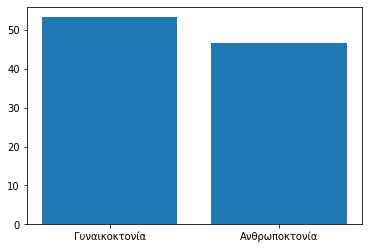

text     0
label    0
dtype: int64

In [13]:
label_distribution = (df['label'].value_counts() * 100) / len(df)
plt.bar(label_distribution.index, label_distribution)
# See class distribution:
plt.show()

# See missing values:
df.isna().sum()


# Split data set to train and test

In [16]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state=25)

#Split to train validate and test
# df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")
# print(f"No. of validatig examples: {df_validate.shape[0]}")

# Get X_train, y_train, X_val, y_val, X_test, y_test

X_train = df_train['text']
y_train = df_train['label']

# X_val = df_validate['text']
# y_val = df_validate['label']

X_test = df_test['text']
y_test = df_test['label']



No. of training examples: 276
No. of testing examples: 69


# Kfold cross validation:

In [17]:
# Prepare cross validation (use random_state and shuffle for reproducible results)
n=5
kf = KFold(n_splits=n, random_state=42, shuffle=True)

results = []

for train_index, val_index in kf.split(df_train):
  print("TRAIN:", train_index, "VAL:", val_index)
  
  # train the model
  # validate the model 
  # append model score
    



TRAIN: [  0   1   2   3   4   5   7   8  11  12  13  14  16  17  18  20  21  23
  26  27  28  29  31  32  33  34  35  36  37  38  39  40  41  43  44  47
  48  49  50  51  52  53  54  55  56  57  58  59  61  62  63  64  65  67
  69  70  71  72  74  76  77  78  80  81  82  83  85  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 110
 111 112 113 115 116 118 119 121 122 123 125 128 129 130 131 133 134 135
 136 137 138 139 141 145 146 147 148 149 150 151 153 155 156 157 160 161
 162 163 165 166 167 169 170 171 172 173 174 176 177 178 179 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 197 198 199 200 202 205
 207 208 209 211 212 213 214 215 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 232 235 236 238 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 255 256 257 258 259 261 262 263 266 267 268 269 270 271
 272 273 274 275] VAL: [  6   9  10  15  19  22  24  25  30  42  45  46  60  66  68  73  75  79
  84  86 109 114 117 